<a href="https://colab.research.google.com/github/josephcabezas/Olist-Ecommerce-Data-Analysis/blob/main/python/olist_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database")

print("Path to dataset files:", path)

100%|██████████| 48.7M/48.7M [00:00<00:00, 59.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database/versions/1


In [8]:
import sqlite3

db_path = '/root/.cache/kagglehub/datasets/terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database/versions/1/olist.sqlite'
db_connection = sqlite3.connect(db_path)

In [4]:
import pandas as pd

def view_table(table, limit):
    query = f"""
        SELECT *
        FROM {table}
        LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)

In [9]:
# table orders, 5 rows, 3 columns
view_table('orders', 5).iloc[:, :3]

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered


In [11]:
# count number of daily orders
order_per_day = """
SELECT DATE(order_purchase_timestamp) AS day, COUNT(*) AS order_count
FROM orders
GROUP BY day
ORDER BY day
"""

df = pd.read_sql_query(order_per_day, db_connection)
df.head()

,day,order_count
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


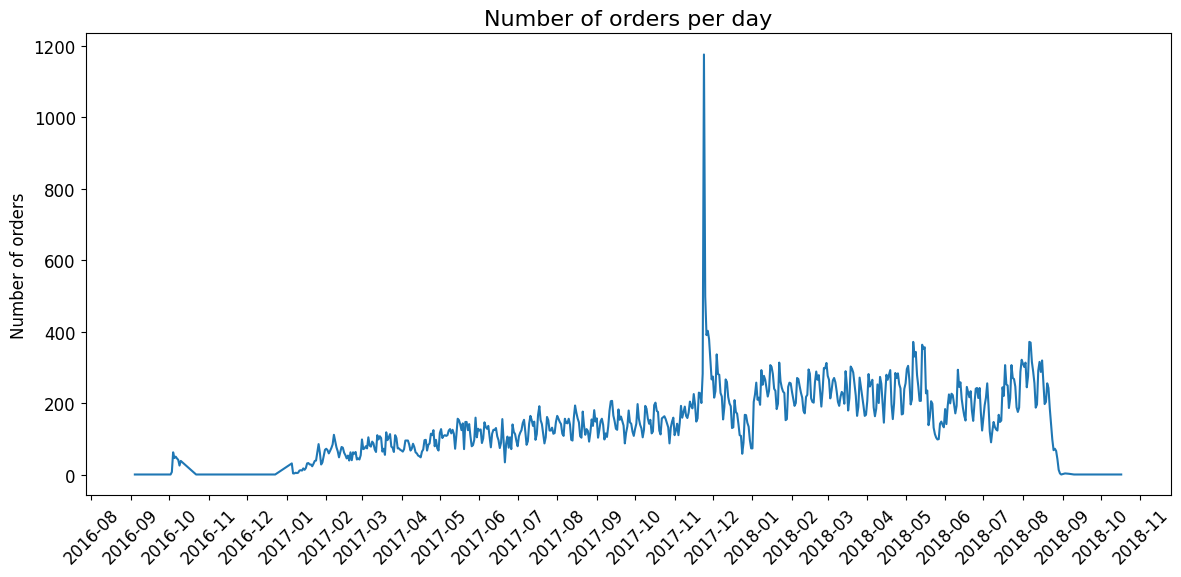

In [13]:
# data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Increase the default font size globally
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

# Line plot
plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(df['day']), df['order_count'])
plt.ylabel('Number of orders')
plt.title('Number of orders per day')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

- order spike around christmas

In [15]:
# how are orders distributed over the week
order_day_hour = """
SELECT
    -- abr days of week
    CASE strftime('%w', order_purchase_timestamp)
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
        WHEN '0' THEN 'Sunday'
        END AS day_of_week_name,
    -- day of week as integer (sunday=7)
    CAST (strftime('%w', order_purchase_timestamp) AS INT) AS day_of_week_int,
    -- hour of the day (0-24)
    CAST (strftime('%H', order_purchase_timestamp) AS INT) AS hour
FROM orders
"""

pd.read_sql_query(order_day_hour, db_connection)

,day_of_week_name,day_of_week_int,hour
0,Monday,1,10
1,Tuesday,2,20
2,Wednesday,3,8
3,Saturday,6,19
4,Tuesday,2,21
...,...,...,...
99436,Thursday,4,9
99437,Tuesday,2,12
99438,Sunday,0,14
99439,Monday,1,21


In [17]:
count_orders_per_hour = ',\n    '.join([
    f'COUNT(CASE WHEN hour = {i} THEN 1 END) AS "{i}"' \
    for i in range(24)
])

orders_per_day_of_the_week_and_hour = f"""
WITH OrderDayHour AS (
    {order_day_hour}
)
SELECT
    day_of_week_name,
    {count_orders_per_hour}
FROM OrderDayHour
GROUP BY day_of_week_int
ORDER BY day_of_week_int
"""

df = pd.read_sql_query(orders_per_day_of_the_week_and_hour, db_connection)
df = df.set_index('day_of_week_name')
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week_name,,,,,,,,,,,,,,,,,,,,,
Sunday,267,141,69,44,27,27,34,105,205,349,...,684,716,712,797,895,899,967,889,873,607
Monday,328,134,66,36,21,22,69,160,479,783,...,1096,1079,1094,992,928,945,1027,1118,991,717
Tuesday,306,158,80,28,29,24,71,223,522,864,...,1124,1047,1081,967,877,924,988,1027,965,692
Wednesday,397,179,81,33,33,27,93,211,517,829,...,1050,983,1040,967,852,848,904,963,878,615
Thursday,355,167,75,39,31,28,85,220,502,758,...,977,928,1077,909,784,826,839,840,857,551
Friday,426,216,72,49,40,36,97,206,493,768,...,961,979,974,817,723,784,738,726,702,512
Saturday,315,175,67,43,25,24,53,106,249,434,...,677,722,697,701,710,756,730,654,550,429


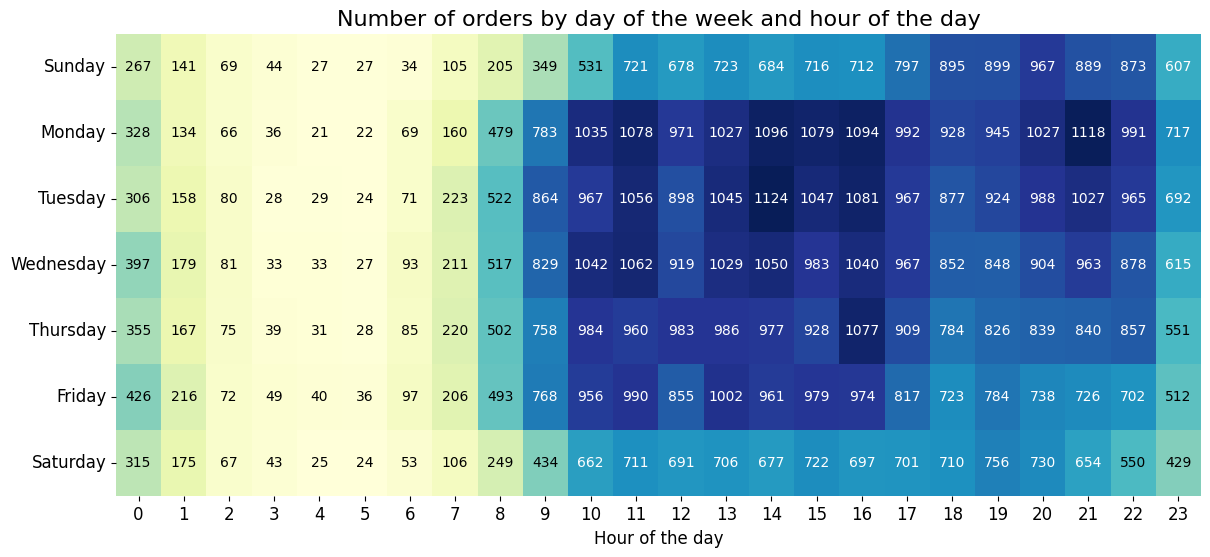

In [18]:
# data visualization, make heat map
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df, cmap='YlGnBu', cbar=False)
mean_orders = df.mean().mean()
for i in range(len(df)):
    for j in range(len(df.columns)):
        text_color = 'white' if df.iloc[i, j] > mean_orders else 'black'
        ax.text(j+0.5, i+0.5, int(df.iloc[i, j]),
            color=text_color, fontsize=10, ha="center", va="center")
plt.title("Number of orders by day of the week and hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("")
plt.show()

most orders from 10 am to 4 pm, with a slight dip during 12 pm lunch time. Saturday is the least busy day

In [19]:
view_table('customers', 5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [20]:
# what does the data say about cities?
orders_per_city = """
SELECT
    customer_city AS customer_city,
    UPPER(customer_city) AS city,
    COUNT(orders.order_id) as city_order_count
FROM
    customers
    JOIN orders USING (customer_id)
GROUP BY customer_city
ORDER BY city_order_count DESC
LIMIT 10
"""

pd.read_sql_query(orders_per_city, db_connection)

,customer_city,city,city_order_count
0,sao paulo,SAO PAULO,15540
1,rio de janeiro,RIO DE JANEIRO,6882
2,belo horizonte,BELO HORIZONTE,2773
3,brasilia,BRASILIA,2131
4,curitiba,CURITIBA,1521
5,campinas,CAMPINAS,1444
6,porto alegre,PORTO ALEGRE,1379
7,salvador,SALVADOR,1245
8,guarulhos,GUARULHOS,1189
9,sao bernardo do campo,SAO BERNARDO DO CAMPO,938


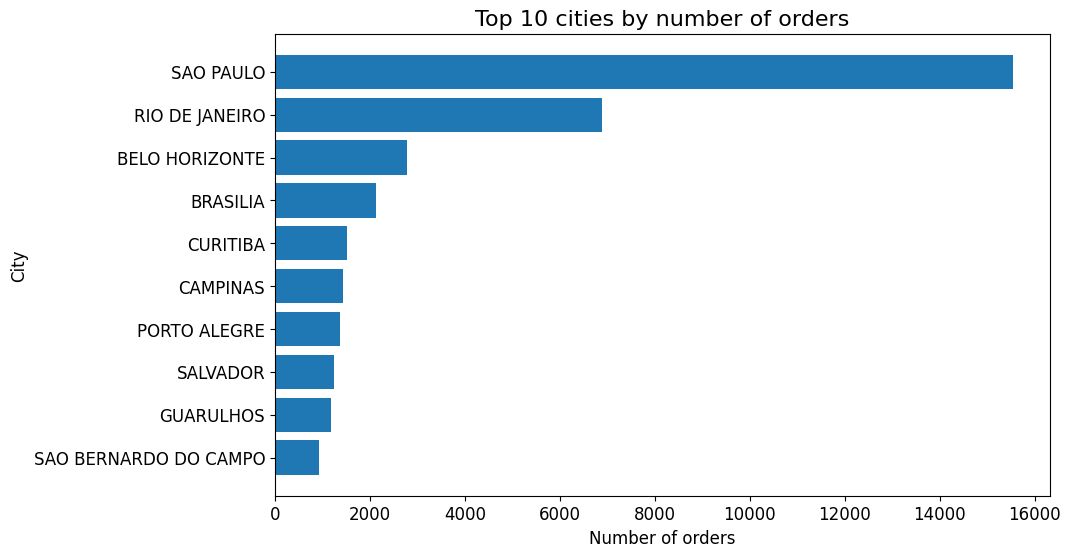

In [21]:
# data visualization
orders_per_city_reversed = f"""
SELECT *
FROM ({orders_per_city})
ORDER BY city_order_count
"""

top_cities = pd.read_sql_query(orders_per_city_reversed, db_connection)

plt.figure(figsize=(10, 6))
plt.barh(top_cities['city'], top_cities['city_order_count'])
plt.xlabel('Number of orders')
plt.ylabel('City')
plt.title('Top 10 cities by number of orders')
plt.show()

Sao Paulo and Rio De Janeiro have the most orders by far compared to other cities

In [22]:
view_table('order_items', 5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [24]:
# what's the average order price, incl shipping
order_price_stats = """
SELECT
    MIN(order_price) AS min_order_price,
    ROUND(AVG(order_price), 2) AS avg_order_price,
    MAX(order_price) AS max_order_price
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS order_price
    FROM orders
        JOIN order_items USING (order_id)
    GROUP BY orders.order_id
)
"""

pd.read_sql_query(order_price_stats, db_connection)

,min_order_price,avg_order_price,max_order_price
0,9.59,160.58,13664.08


In [25]:
order_product_and_shipping_costs = """
SELECT
    orders.order_id,
    SUM(price) AS product_cost,
    SUM(freight_value) AS shipping_cost
FROM
    orders
    JOIN order_items USING (order_id)
WHERE order_status = 'delivered'
GROUP BY orders.order_id
"""

df = pd.read_sql_query(order_product_and_shipping_costs, db_connection)
df

,order_id,product_cost,shipping_cost
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
96474,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
96475,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
96476,fffe18544ffabc95dfada21779c9644f,55.99,8.72


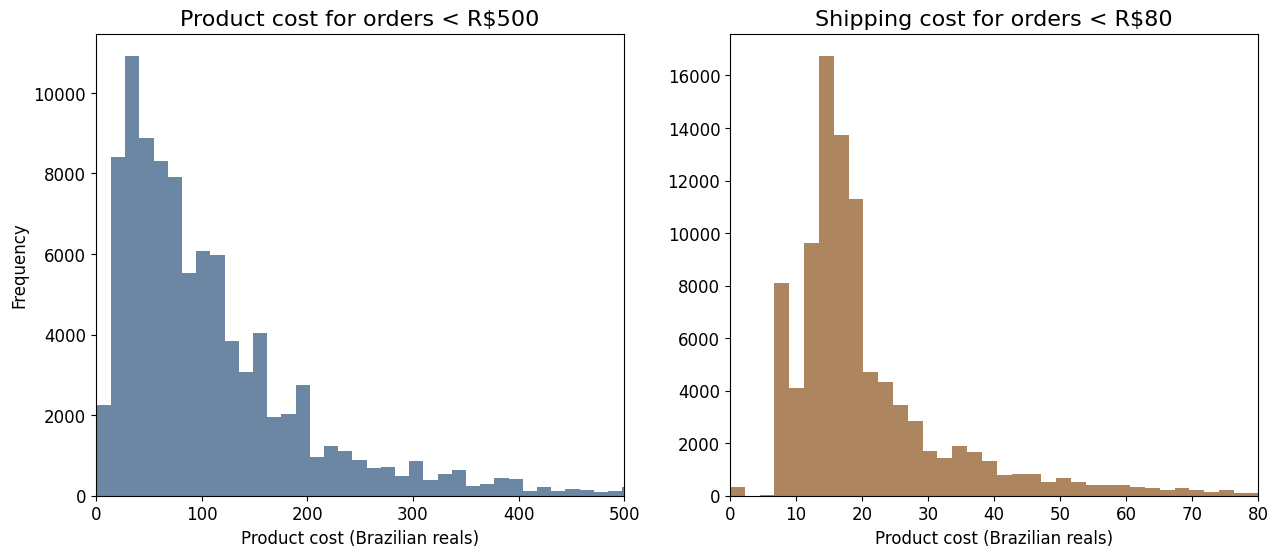

In [26]:
# data visualization
plt.figure(figsize=(15, 6))
# Histogram for total product cost
plt.subplot(1, 2, 1)
plt.hist(df['product_cost'], bins=1000, color='#6c87a3')
plt.title('Product cost for orders < R$500')
plt.xlabel('Product cost (Brazilian reals)')
plt.ylabel('Frequency')
plt.xlim([0, 500])
# Histogram for total shipping cost
plt.subplot(1, 2, 2)
plt.hist(df['shipping_cost'], bins=800, color='#ad865f')
plt.title('Shipping cost for orders < R$80')
plt.xlabel('Product cost (Brazilian reals)')
plt.xlim([0, 80])
plt.show()

In [27]:
view_table('products', 5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [28]:
ranked_categories = """
SELECT
    product_category_name_english AS category,
    SUM(price) AS sales,
    RANK() OVER (ORDER BY SUM(price) DESC) AS rank
FROM order_items
    JOIN orders USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
"""

pd.read_sql_query(ranked_categories, db_connection)

,category,sales,rank
0,health_beauty,1233131.72,1
1,watches_gifts,1166176.98,2
2,bed_bath_table,1023434.76,3
3,sports_leisure,954852.55,4
4,computers_accessories,888724.61,5
...,...,...,...
66,flowers,1110.04,67
67,home_comfort_2,760.27,68
68,cds_dvds_musicals,730.00,69
69,fashion_childrens_clothes,519.95,70


In [29]:
# rank the top 17 categories, then group everything else in number 18
category_sales_summary = f"""
WITH RankedCategories AS (
    {ranked_categories}
)
-- Top 18 categories by sales
SELECT
    category,
    sales
FROM RankedCategories
WHERE rank <= 18
-- Other categories, aggregated
UNION ALL
SELECT
    'Other categories' AS category,
    SUM(sales) AS sales
FROM RankedCategories
WHERE rank > 18
"""

df = pd.read_sql_query(category_sales_summary, db_connection)
df

,category,sales
0,health_beauty,1233131.72
1,watches_gifts,1166176.98
2,bed_bath_table,1023434.76
3,sports_leisure,954852.55
4,computers_accessories,888724.61
5,furniture_decor,711927.69
6,housewares,615628.69
7,cool_stuff,610204.10
8,auto,578966.65
9,toys,471286.48


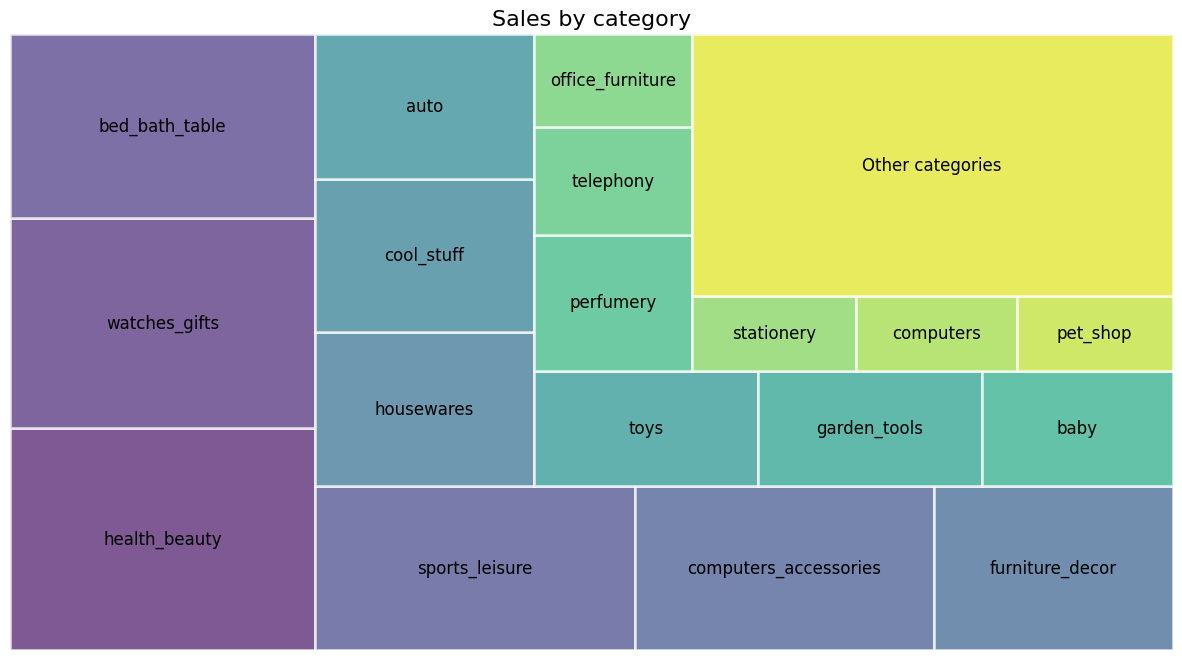

In [31]:
# data visualization
!pip install squarify
import squarify

plt.figure(figsize=(15, 8))
plt.title('Sales by category')
color = sns.color_palette("viridis", len(df))
squarify.plot(sizes=df['sales'], label=df['category'],
              alpha=0.7, color=color, edgecolor="white", linewidth=2)
plt.axis('off')
plt.show()

In [32]:
top_18_categories = tuple(category for category in df['category'] if category != 'Other categories')

In [33]:
ordered_categories = f"""
SELECT
    product_weight_g AS weight,
    product_category_name_english AS category,
    ROW_NUMBER() OVER(PARTITION BY product_category_name_english ORDER BY product_weight_g)
        AS category_row_n,
    COUNT(*) OVER(PARTITION BY product_category_name_english) AS category_count
FROM
    products
    JOIN order_items USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    product_category_name_english IN {top_18_categories}
"""

df = pd.read_sql_query(ordered_categories, db_connection)
df

,weight,category,category_row_n,category_count
0,50.0,auto,1,4235
1,50.0,auto,2,4235
2,50.0,auto,3,4235
3,50.0,auto,4,4235
4,50.0,auto,5,4235
...,...,...,...,...
92419,15267.0,watches_gifts,5987,5991
92420,15267.0,watches_gifts,5988,5991
92421,15267.0,watches_gifts,5989,5991
92422,17175.0,watches_gifts,5990,5991


In [34]:
categories_by_median = f"""
WITH OrderedCategories AS (
    {ordered_categories}
)
SELECT category
FROM OrderedCategories
WHERE
    -- Odd number of products: Select the middle row
    (category_count % 2 = 1 AND category_row_n = (category_count + 1) / 2) OR
    -- Even number of products: Select the two middle rows to be averaged
    (category_count % 2 = 0 AND category_row_n IN ((category_count / 2), (category_count / 2 + 1)))
GROUP BY category
ORDER BY AVG(weight)
"""

categories_by_median_df = pd.read_sql_query(categories_by_median, db_connection)
categories_by_median_df

,category
0,telephony
1,computers_accessories
2,watches_gifts
3,health_beauty
4,perfumery
5,baby
6,sports_leisure
7,toys
8,pet_shop
9,auto


<ipython-input-37-4bd761771210>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='weight', y='category', data=df, order=order, palette='deep', showfliers=False)


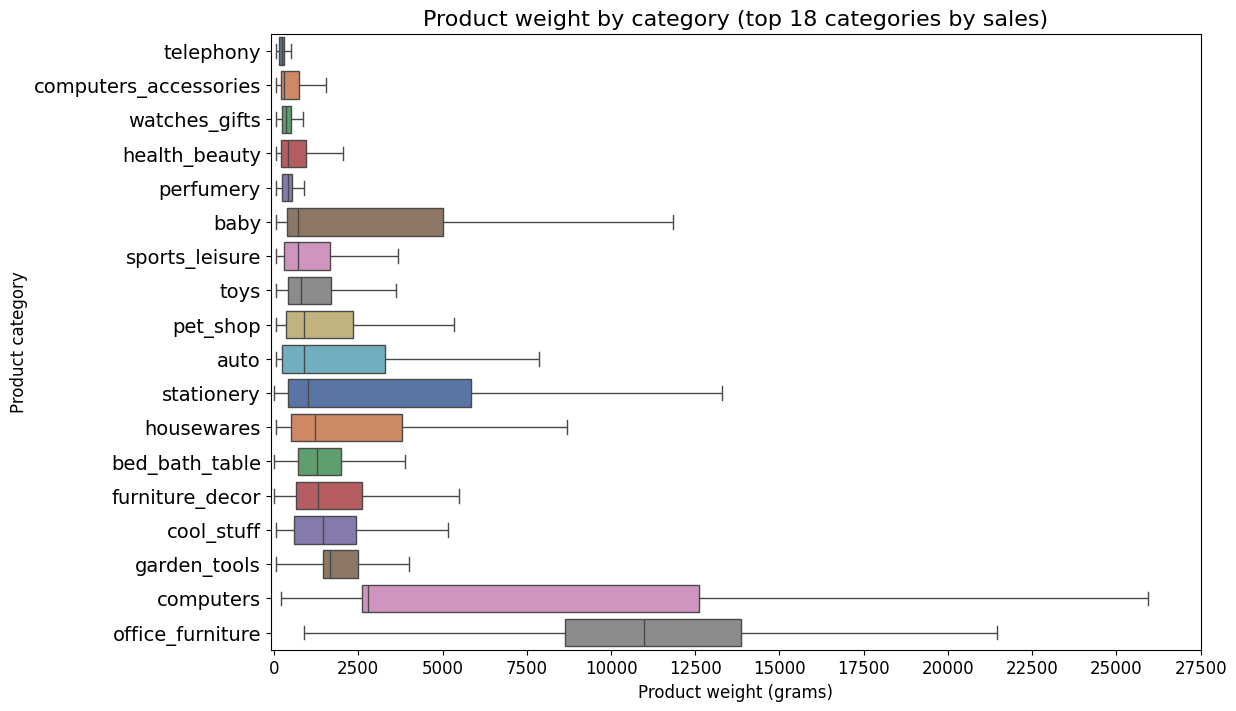

In [37]:
# data visualization, box plots
plt.figure(figsize=(12, 8))
order = categories_by_median_df['category'].tolist()
sns.boxplot(x='weight', y='category', data=df, order=order, palette='deep', showfliers=False)
plt.xlabel('Product weight (grams)')
plt.ylabel('Product category')
plt.title('Product weight by category (top 18 categories by sales)')
plt.xlim(-100, 26100)
plt.xticks(ticks=range(0, 30000, 2500))
plt.yticks(fontsize=14)
plt.show()

In [38]:
# sales prediction
selected_categories = ('health_beauty', 'auto', 'toys', 'electronics', 'fashion_shoes')

In [39]:
monthly_sales_selected_categories = f"""
SELECT
    strftime('%Y-%m', order_purchase_timestamp) AS year_month,
    SUM(CASE WHEN product_category_name_english = 'health_beauty' THEN price END) AS health_beauty,
    SUM(CASE WHEN product_category_name_english = 'auto' THEN price END) AS auto,
    SUM(CASE WHEN product_category_name_english = 'toys' THEN price END) AS toys,
    SUM(CASE WHEN product_category_name_english = 'electronics' THEN price END) AS electronics,
    SUM(CASE WHEN product_category_name_english = 'fashion_shoes' THEN price END) AS fashion_shoes
FROM orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_purchase_timestamp >= '2017-01-01'
    AND product_category_name_english IN {selected_categories}
GROUP BY year_month
"""

df = pd.read_sql_query(monthly_sales_selected_categories, db_connection)
df = df.set_index('year_month')
df

,health_beauty,auto,toys,electronics,fashion_shoes
year_month,,,,,
2017-01,12561.32,5218.53,4814.09,617.00,34.90
2017-02,22838.79,13162.40,9403.34,1218.85,107.05
2017-03,25995.25,14482.07,12429.47,3986.00,1515.00
2017-04,22935.75,15548.17,13039.43,4822.24,1526.50
2017-05,46786.02,18640.03,22626.95,6709.11,1669.54
2017-06,32029.39,31370.69,15476.35,2100.04,1351.20
2017-07,34896.86,14119.74,24511.72,7346.84,1423.01
2017-08,49873.90,20421.11,18126.87,2854.15,1491.69
2017-09,51537.65,14544.67,31399.22,4338.96,1179.60


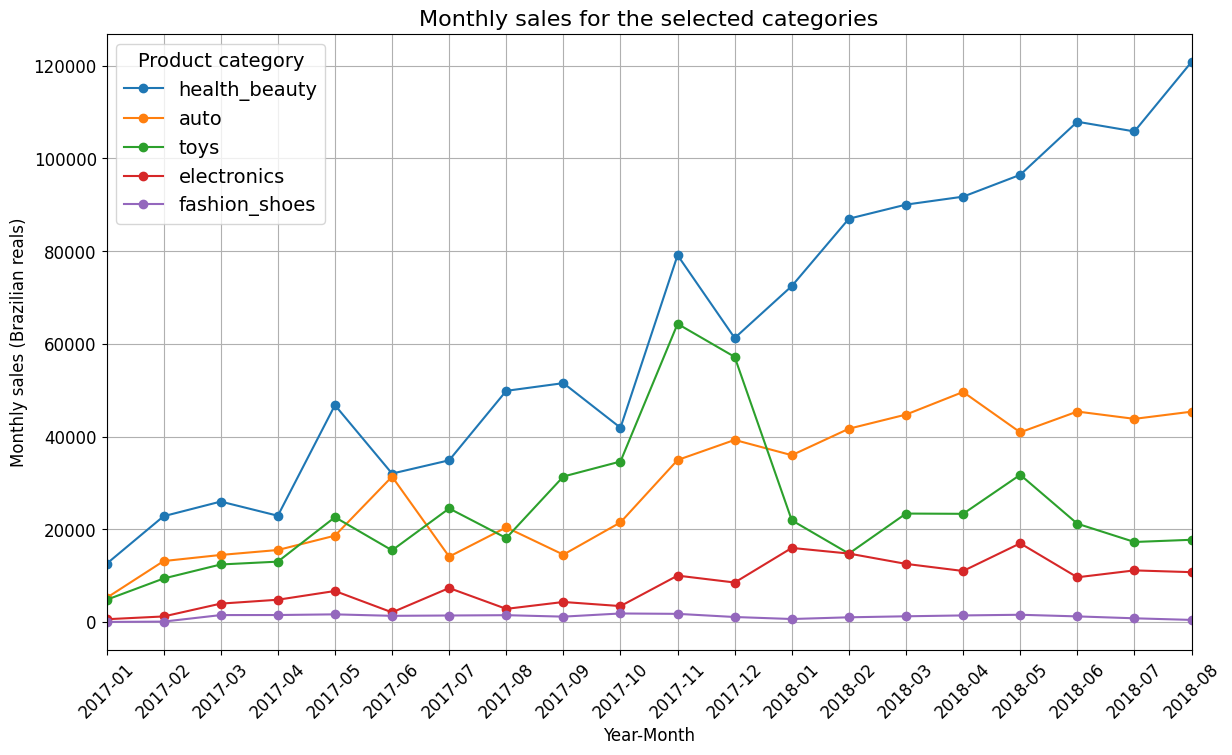

In [40]:
# data visualization
df.index = pd.to_datetime(df.index)
fig, ax = plt.subplots(figsize=(14, 8))
df.plot(ax=ax, marker='o', linestyle='-')
ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%Y-%m'), rotation=90)
plt.title('Monthly sales for the selected categories')
plt.xlabel('Year-Month')
plt.ylabel('Monthly sales (Brazilian reals)')
plt.xticks(rotation=45)
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

health and beauty has consistenly been the top selling category. Categories like health and beauty, auto, and electronics are experiencing boom growth. Toys booms during the holidays but then sharply falls. Fashion shoes has been very stagnant.

In [41]:
daily_sales_per_category = f"""
SELECT
    DATE(order_purchase_timestamp) AS date,
    -- Days since 2017-01-01
    CAST(JULIANDAY(order_purchase_timestamp) - JULIANDAY('2017-01-01') AS INTEGER) AS day,
    product_category_name_english AS category,
    SUM(price) AS sales
FROM
    orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    order_purchase_timestamp BETWEEN '2017-01-01' AND '2018-08-29'
    AND category IN {selected_categories}
GROUP BY
    day,
    product_category_name_english
"""

df = pd.read_sql_query(daily_sales_per_category, db_connection)
df

,date,day,category,sales
0,2017-01-05,4,auto,21.80
1,2017-01-05,4,toys,43.80
2,2017-01-06,5,health_beauty,636.00
3,2017-01-06,5,toys,159.99
4,2017-01-07,6,health_beauty,370.00
...,...,...,...,...
2440,2018-08-27,603,auto,343.38
2441,2018-08-27,603,health_beauty,661.50
2442,2018-08-27,603,toys,257.79
2443,2018-08-28,604,auto,124.00


In [42]:
# set up linear regression
daily_sales_per_category = f"""
SELECT
    DATE(order_purchase_timestamp) AS date,
    -- Days since 2017-01-01
    CAST(JULIANDAY(order_purchase_timestamp) - JULIANDAY('2017-01-01') AS INTEGER) AS day,
    product_category_name_english AS category,
    SUM(price) AS sales
FROM
    orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    order_purchase_timestamp BETWEEN '2017-01-01' AND '2018-08-29'
    AND category IN {selected_categories}
GROUP BY
    day,
    product_category_name_english
"""

pd.read_sql_query(daily_sales_per_category, db_connection)

,date,day,category,sales
0,2017-01-05,4,auto,21.80
1,2017-01-05,4,toys,43.80
2,2017-01-06,5,health_beauty,636.00
3,2017-01-06,5,toys,159.99
4,2017-01-07,6,health_beauty,370.00
...,...,...,...,...
2440,2018-08-27,603,auto,343.38
2441,2018-08-27,603,health_beauty,661.50
2442,2018-08-27,603,toys,257.79
2443,2018-08-28,604,auto,124.00


In [44]:
lm_per_category = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
)
SELECT
    category,
    -- Slope
    (COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) /
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))
        AS slope,
    -- Intercept
    (SUM(sales) -
        ((COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) /
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))) *
        SUM(day)) / COUNT(*)
        AS intercept
FROM
    DailySalesPerCategory
GROUP BY
    category
"""

df = pd.read_sql_query(lm_per_category, db_connection)
df

,category,slope,intercept
0,auto,2.257831,319.055318
1,electronics,0.614535,105.302974
2,fashion_shoes,0.126815,89.637179
3,health_beauty,5.876734,305.451543
4,toys,0.563910,649.648518


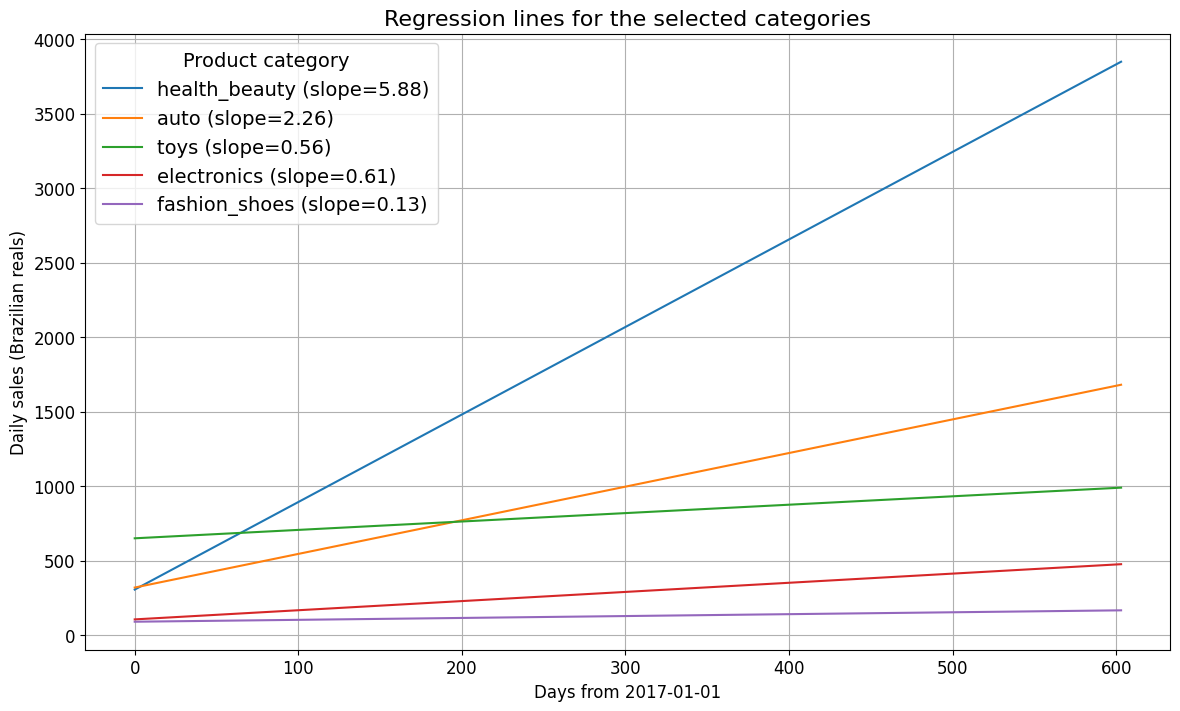

In [46]:
# data visualization
import numpy as np

plt.figure(figsize=(14, 8))
days = np.arange(0, 604)
for category in selected_categories:
    lm = df[df['category'] == category]
    slope = lm['slope'].values[0]
    intercept = lm['intercept'].values[0]
    line = intercept + slope * days
    plt.plot(days, line, label=f'{category} (slope={slope:.2f})')
plt.title('Regression lines for the selected categories')
plt.xlabel('Days from 2017-01-01')
plt.ylabel('Daily sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

In [47]:
# sales forecast
forecasted_sales_dec_2018 = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
),
LmPerCategory AS (
    {lm_per_category}
),
ForecastedSales AS (
    SELECT
        DATE(date, '+1 year') AS date,
        category,
        -- Increase in predicted sales * sales 1 year ago
        (intercept + slope * (day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)))
            / (intercept + slope * day) * sales
            AS forecasted_sales
    FROM DailySalesPerCategory
        JOIN LmPerCategory USING (category)
    -- Filter for days of December 2018
    WHERE day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)
        BETWEEN CAST(JULIANDAY('2018-12-01') - JULIANDAY('2017-01-01') AS INTEGER)
        AND CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-01-01') AS INTEGER)
)
SELECT
    CAST(strftime('%d', date) AS INTEGER) AS december_2018_day,
    category,
    -- 5-day moving average
    AVG(forecasted_sales)
        OVER (PARTITION BY category ORDER BY date ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING)
        AS moving_avg_sales
FROM ForecastedSales
"""

forecast_2018_12_df = pd.read_sql_query(forecasted_sales_dec_2018, db_connection)
forecast_2018_12_df

,december_2018_day,category,moving_avg_sales
0,1,auto,2438.257278
1,2,auto,2957.096207
2,3,auto,2612.112277
3,4,auto,3034.655653
4,5,auto,2919.956942
...,...,...,...
126,27,toys,1247.841517
127,28,toys,857.343323
128,29,toys,585.209963
129,30,toys,621.773116


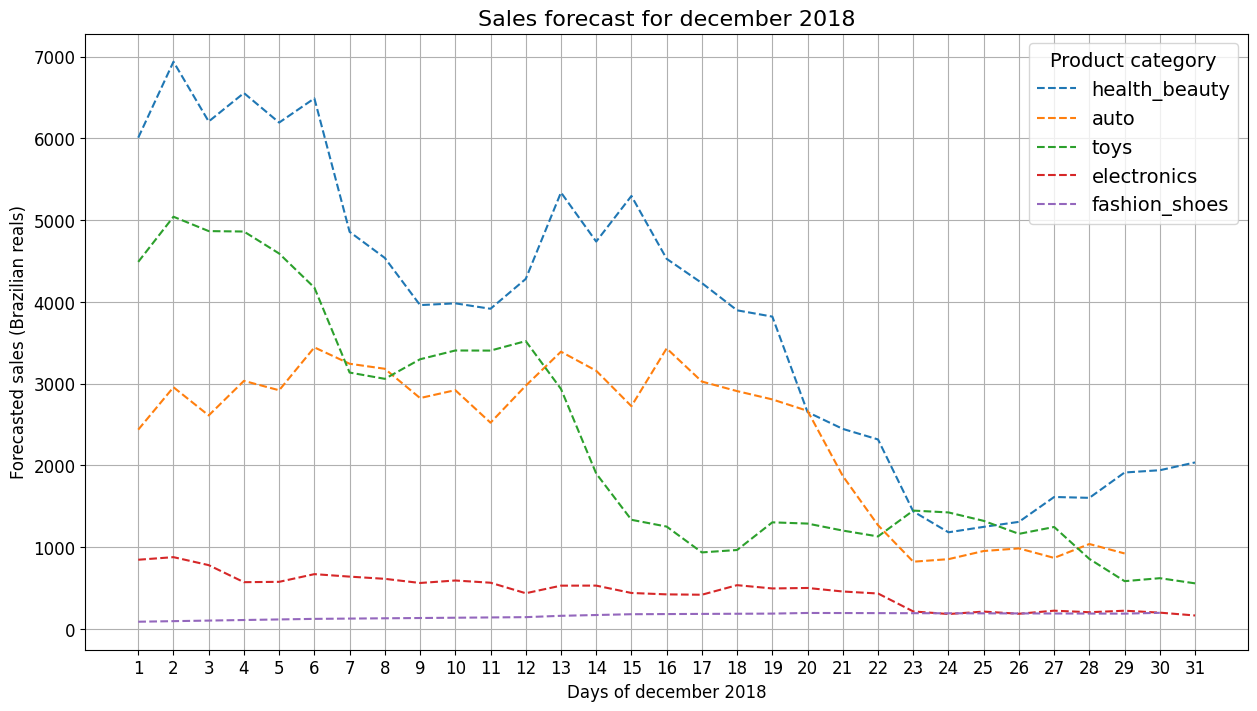

In [48]:
# data visualization
plt.figure(figsize=(15, 8))
for category in selected_categories:
    category_forecast = forecast_2018_12_df[forecast_2018_12_df['category'] == category]
    plt.plot(category_forecast['december_2018_day'], category_forecast['moving_avg_sales'], '--', label=category)
plt.title('Sales forecast for december 2018')
plt.xlabel('Days of december 2018')
plt.ylabel('Forecasted sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.xticks(range(1, 32))
plt.show()

the model predicts that health and beauty will be the highest selling category of the five we examined, and its sales will slowly go down until Christmas. toys will have strong sales for the first two weeks but decline sharply after that. auto sales remain stable for the first 3 weeks, but they'll go down afterward. electronics follows a similar trend but fashion_shoes sales seem to be independent of the holiday trends, increasing slightly at the end of the month.

In [49]:
order_stage_times_top_10_citites = f"""
SELECT
    UPPER(customer_city)
        AS city,
    AVG(JULIANDAY(order_approved_at) - JULIANDAY(order_purchase_timestamp))
        AS approved,
    AVG(JULIANDAY(order_delivered_carrier_date) - JULIANDAY(order_approved_at))
        AS delivered_to_carrier,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_delivered_carrier_date))
        AS delivered_to_customer,
    AVG(JULIANDAY(order_estimated_delivery_date) - JULIANDAY(order_delivered_customer_date))
        AS estimated_delivery
FROM orders
    JOIN customers USING (customer_id)
WHERE  customer_city IN {tuple(top_cities['customer_city'])}
GROUP BY  customer_city
ORDER BY approved + delivered_to_carrier + delivered_to_customer DESC
"""

df = pd.read_sql_query(order_stage_times_top_10_citites, db_connection)
df = df.set_index('city')
df

,approved,delivered_to_carrier,delivered_to_customer,estimated_delivery
city,,,,
SALVADOR,0.498863,2.700868,16.160566,8.755085
PORTO ALEGRE,0.420697,2.809786,12.786769,11.091915
RIO DE JANEIRO,0.383342,2.979133,11.409813,12.504991
BRASILIA,0.432585,2.762064,9.805472,11.333709
BELO HORIZONTE,0.378608,2.848813,7.900486,11.901479
CURITIBA,0.453929,2.690824,7.316206,12.732135
CAMPINAS,0.420262,2.784653,6.611740,8.821432
SAO BERNARDO DO CAMPO,0.349693,2.702651,5.045101,9.799631
SAO PAULO,0.385928,2.726784,4.961921,10.027349


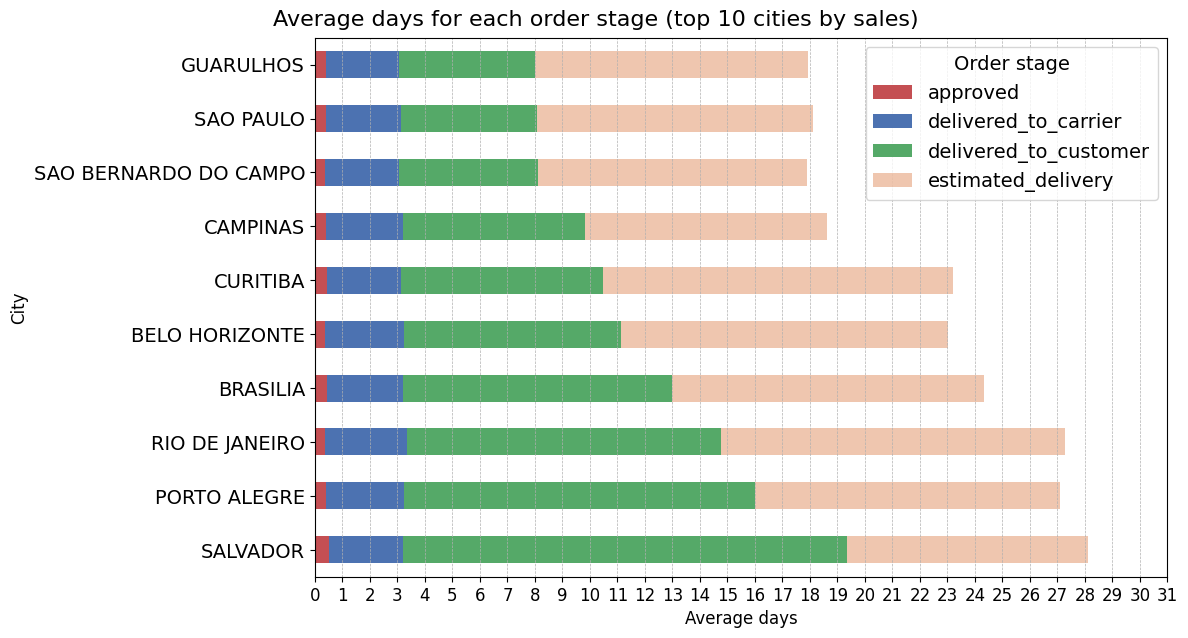

In [50]:
# data visualization
fig, ax = plt.subplots(figsize=(11, 7))
df.plot(kind='barh', stacked=True, color=['#c44f53', '#4c72b1', '#55a968', '#dd845275'], ax=ax)
ax.set_xlabel('Average days')
ax.set_ylabel('City')
fig.suptitle('Average days for each order stage (top 10 cities by sales)', fontsize=16, x=0.38, y=0.92)
ax.grid(True, linestyle='--', linewidth=0.5, axis='x')
max_bar_length = int(df.sum(axis=1).max())
ax.set_xticks(range(0, max_bar_length + 4))
ax.tick_params(axis='y', labelsize=14)
plt.legend(title='Order stage', title_fontsize=14, fontsize=14)
plt.show()

varying shipping times. Sao Paulo being the second quickest is great because it has the highest order volume. However, it is troubling seeing Rio De Janeiro so slow when it has the second highest order volume

In [52]:
# is there a seasonal variation in shipping times
daily_avg_shipping_time = """
SELECT
    DATE(order_purchase_timestamp) AS purchase_date,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp))
        AS avg_delivery_time
FROM orders
WHERE order_purchase_timestamp >= '2017-06-01' AND order_purchase_timestamp <= '2018-06-30'
GROUP BY DATE(order_purchase_timestamp)
"""

df = pd.read_sql_query(daily_avg_shipping_time, db_connection)
df

,purchase_date,avg_delivery_time
0,2017-06-01,11.238623
1,2017-06-02,12.079623
2,2017-06-03,14.255051
3,2017-06-04,12.064359
4,2017-06-05,11.101563
...,...,...
389,2018-06-25,7.280438
390,2018-06-26,8.173340
391,2018-06-27,8.854751
392,2018-06-28,8.601704


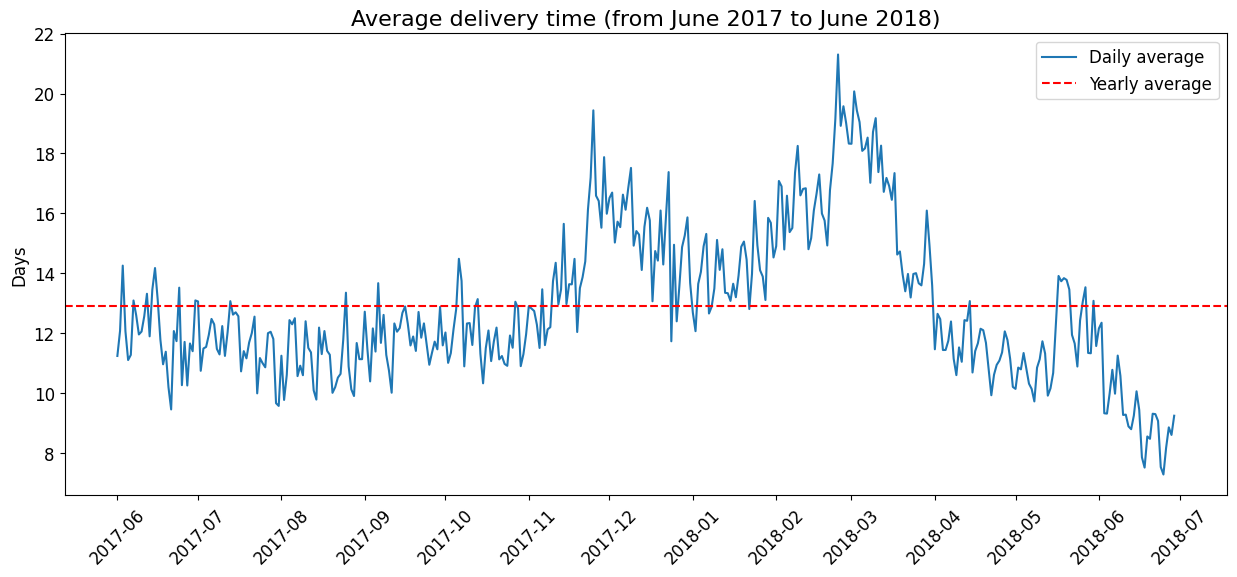

In [53]:
# data visualization
plt.figure(figsize=(15, 6))
plt.plot(pd.to_datetime(df['purchase_date']), df['avg_delivery_time'], label='Daily average')
plt.axhline(y=df['avg_delivery_time'].mean(), color='r', linestyle='--', label='Yearly average')
plt.ylabel('Days')
plt.title('Average delivery time (from June 2017 to June 2018)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.legend()
plt.show()

december 2017-march 2018 had much higher shipping times

In [54]:
view_table('order_reviews', 5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [55]:
review_score_count = """
SELECT
    review_score,
    COUNT(*) AS count
FROM order_reviews
GROUP BY review_score
"""
df = pd.read_sql_query(review_score_count, db_connection)
df

,review_score,count
0,1,11424
1,2,3151
2,3,8179
3,4,19142
4,5,57328


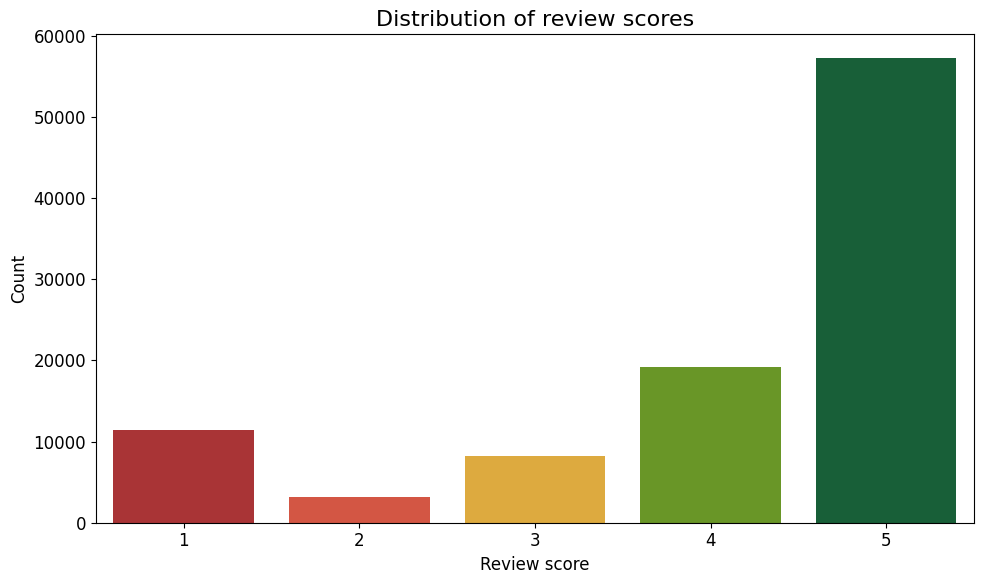

In [56]:
# data visualization
plt.figure(figsize=(10,6))
colors = ['#BC2023', '#EB442C', '#F8B324', '#6da814', '#0C6B37']
sns.barplot(x='review_score', y='count', data=df, hue='review_score', palette=colors, dodge=False)
plt.title('Distribution of review scores')
plt.xlabel('Review score')
plt.ylabel('Count')
plt.legend().remove()
plt.tight_layout()
plt.show()

Mostly positive reviews, but what is the cause for the significant clump of 1 star reviews?

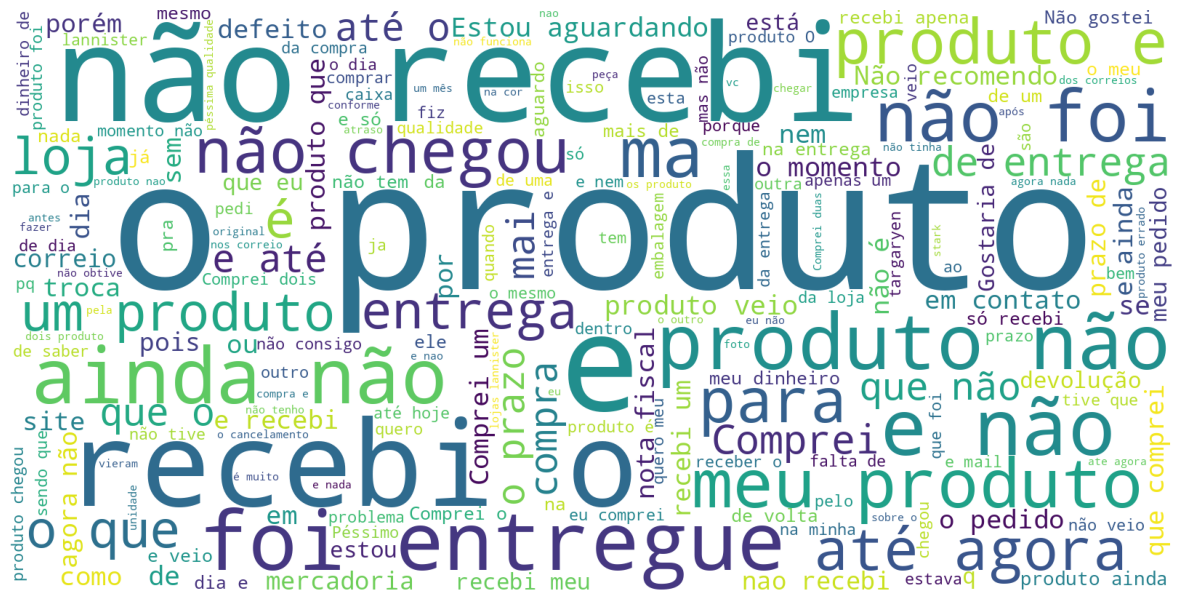

In [59]:
#Create a word cloud to gain insight into negative reviews

negative_comments = """
SELECT GROUP_CONCAT(review_comment_message, ' ') AS comments
FROM order_reviews
WHERE review_score IN (1,2)
"""

negative_comments_df = pd.read_sql(negative_comments, db_connection)['comments'][0]

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(negative_comments_df)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

translating some of these phrases, the most common complaint has to do with shipping delays

In [60]:
# customer segmentation by recency, frequency and monetary value (RFM)
rfm_buckets = """
-- 1. Calculate RFM scores
WITH RecencyScore AS (
    SELECT customer_unique_id,
           MAX(order_purchase_timestamp) AS last_purchase,
           NTILE(5) OVER (ORDER BY MAX(order_purchase_timestamp) DESC) AS recency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
FrequencyScore AS (
    SELECT customer_unique_id,
           COUNT(order_id) AS total_orders,
           NTILE(5) OVER (ORDER BY COUNT(order_id) DESC) AS frequency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
MonetaryScore AS (
    SELECT customer_unique_id,
           SUM(price) AS total_spent,
           NTILE(5) OVER (ORDER BY SUM(price) DESC) AS monetary
    FROM orders
        JOIN order_items USING (order_id)
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),

-- 2. Assign each customer to a group
RFM AS (
    SELECT last_purchase, total_orders, total_spent,
        CASE
            WHEN recency = 1 AND frequency + monetary IN (1, 2, 3, 4) THEN "Champions"
            WHEN recency IN (4, 5) AND frequency + monetary IN (1, 2) THEN "Can't Lose Them"
            WHEN recency IN (4, 5) AND frequency + monetary IN (3, 4, 5, 6) THEN "Hibernating"
            WHEN recency IN (4, 5) AND frequency + monetary IN (7, 8, 9, 10) THEN "Lost"
            WHEN recency IN (2, 3) AND frequency + monetary IN (1, 2, 3, 4) THEN "Loyal Customers"
            WHEN recency = 3 AND frequency + monetary IN (5, 6) THEN "Needs Attention"
            WHEN recency = 1 AND frequency + monetary IN (7, 8) THEN "Recent Users"
            WHEN recency = 1 AND frequency + monetary IN (5, 6) OR
                recency = 2 AND frequency + monetary IN (5, 6, 7, 8) THEN "Potentital Loyalists"
            WHEN recency = 1 AND frequency + monetary IN (9, 10) THEN "Price Sensitive"
            WHEN recency = 2 AND frequency + monetary IN (9, 10) THEN "Promising"
            WHEN recency = 3 AND frequency + monetary IN (7, 8, 9, 10) THEN "About to Sleep"
        END AS RFM_Bucket
    FROM RecencyScore
        JOIN FrequencyScore USING (customer_unique_id)
        JOIN MonetaryScore USING (customer_unique_id)
)

-- 3. Calculate group statistics for plotting
SELECT RFM_Bucket,
       AVG(JULIANDAY('now') - JULIANDAY(last_purchase)) AS avg_days_since_purchase,
       AVG(total_spent / total_orders) AS avg_sales_per_customer,
       COUNT(*) AS customer_count
FROM RFM
GROUP BY RFM_Bucket
"""

df = pd.read_sql(rfm_buckets, db_connection)
df

,RFM_Bucket,avg_days_since_purchase,avg_sales_per_customer,customer_count
0,About to Sleep,2467.708149,57.684959,7584
1,Can't Lose Them,2641.011457,350.886817,1723
2,Champions,2294.738714,250.856821,4607
3,Hibernating,2642.021135,182.845816,20288
4,Lost,2644.549912,57.393210,15331
5,Loyal Customers,2425.204178,237.881257,9315
6,Needs Attention,2468.765229,145.904925,6510
7,Potentital Loyalists,2351.899346,130.374773,18114
8,Price Sensitive,2293.363309,34.909351,2220
9,Promising,2384.852981,35.085359,2245


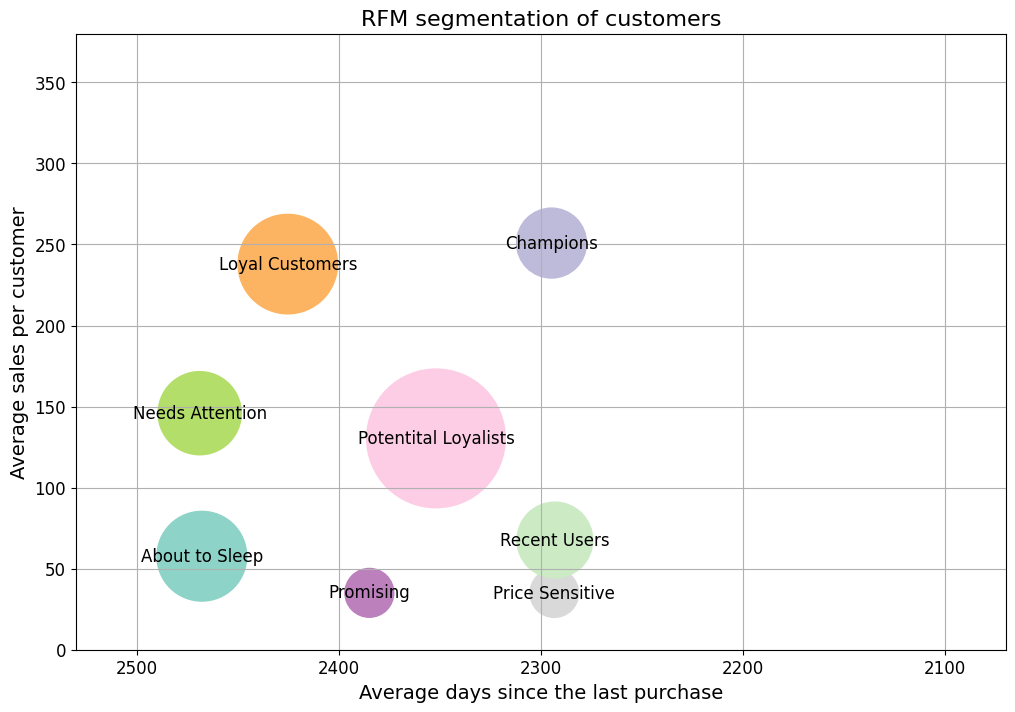

In [61]:
# data visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['avg_days_since_purchase'], df['avg_sales_per_customer'],
    s=df['customer_count']*0.55, c=sns.color_palette('Set3', len(df)))
plt.xlabel('Average days since the last purchase', fontsize=14)
plt.ylabel('Average sales per customer', fontsize=14)
plt.title('RFM segmentation of customers')
plt.grid(True)
for i, text in enumerate(df['RFM_Bucket']):
    plt.annotate(text, (df['avg_days_since_purchase'][i], df['avg_sales_per_customer'][i]),
        ha='center', va='center')
plt.gca().invert_xaxis()
plt.xlim(2530, 2070)
plt.ylim(0, 380)
plt.show()

In [62]:
repeat_customer_proportion = """
WITH CustomerOrders AS (
    SELECT COUNT(orders.order_id) AS order_count
    FROM orders JOIN customers USING (customer_id)
    GROUP BY customers.customer_unique_id
)
SELECT
    CASE WHEN order_count > 1 THEN 'repeat' ELSE 'one-time' END AS order_type,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM CustomerOrders), 1) AS proportion
FROM CustomerOrders
GROUP BY order_type
"""

df = pd.read_sql_query(repeat_customer_proportion, db_connection)
df

,order_type,proportion
0,one-time,96.9
1,repeat,3.1


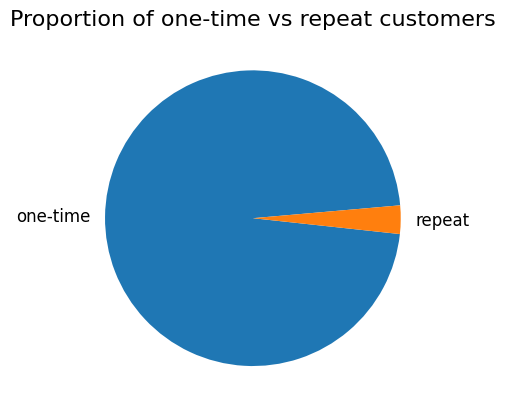

In [63]:
# data visualization, pie chart
fig, ax = plt.subplots()
ax.pie(df['proportion'], labels=df['order_type'], startangle=5)
ax.set_title('Proportion of one-time vs repeat customers')
fig.set_facecolor('white')
plt.show()

In [64]:
view_table('order_payments', 5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [67]:
# customer lifetime value (CLV) via:
# purchase frequency (PF), avg order value (AOV), avg customer lifespan (ACL)
clv = """
WITH CustomerData AS (
    SELECT
        customer_unique_id,
        customer_zip_code_prefix AS zip_code_prefix,
        COUNT(DISTINCT orders.order_id) AS order_count,
        SUM(payment_value) AS total_payment,
        JULIANDAY(MIN(order_purchase_timestamp)) AS first_order_day,
        JULIANDAY(MAX(order_purchase_timestamp)) AS last_order_day
    FROM customers
        JOIN orders USING (customer_id)
        JOIN order_payments USING (order_id)
    GROUP BY customer_unique_id
)
SELECT
    customer_unique_id,
    zip_code_prefix,
    order_count AS PF,
    total_payment / order_count AS AOV,
    CASE
        WHEN (last_order_day - first_order_day) < 7 THEN
            1
        ELSE
            (last_order_day - first_order_day) / 7
        END AS ACL
FROM CustomerData
"""

pd.read_sql(clv, db_connection)

,customer_unique_id,zip_code_prefix,PF,AOV,ACL
0,0000366f3b9a7992bf8c76cfdf3221e2,7787,1,141.90,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,1,27.19,1.0
2,0000f46a3911fa3c0805444483337064,88115,1,86.22,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,66812,1,43.62,1.0
4,0004aac84e0df4da2b147fca70cf8255,18040,1,196.89,1.0
...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,55250,1,2067.42,1.0
96091,fffea47cd6d3cc0a88bd621562a9d061,44054,1,84.58,1.0
96092,ffff371b4d645b6ecea244b27531430a,78552,1,112.46,1.0
96093,ffff5962728ec6157033ef9805bacc48,29460,1,133.69,1.0


In [66]:
view_table('geolocation', 5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [68]:
avg_clv_per_zip_prefix = f"""
WITH CLV AS (
    {clv}
)
SELECT
    zip_code_prefix AS zip_prefix,
    AVG(PF * AOV * ACL) AS avg_CLV,
    COUNT(customer_unique_id) AS customer_count,
    geolocation_lat AS latitude,
    geolocation_lng AS longitude
FROM CLV
    JOIN geolocation ON CLV.zip_code_prefix = geolocation.geolocation_zip_code_prefix
GROUP BY zip_code_prefix
"""

df = pd.read_sql(avg_clv_per_zip_prefix, db_connection)
df

,zip_prefix,avg_CLV,customer_count,latitude,longitude
0,1003,98.970000,17,-23.549032,-46.635313
1,1004,99.055000,44,-23.550116,-46.635122
2,1005,1082.762826,125,-23.549819,-46.635606
3,1006,434.025000,18,-23.550524,-46.636694
4,1007,126.387500,104,-23.550393,-46.637302
...,...,...,...,...,...
14821,99960,97.315000,10,-27.953797,-52.029641
14822,99965,113.795000,12,-28.173892,-52.038447
14823,99970,252.740000,21,-28.345143,-51.876926
14824,99980,111.385000,52,-28.389218,-51.846012


In [69]:
# what products are normally bought together
min_orders = 5

most_ordered_products = f"""
SELECT
    products.product_id,
    product_category_name_english AS category,
    COUNT(order_id) AS orders_count
FROM order_items
    JOIN products USING (product_id)
    JOIN product_category_name_translation AS tr
        ON products.product_category_name = tr.product_category_name
GROUP BY products.product_id
    HAVING COUNT(order_id) > {min_orders}
"""

most_ordered_products_df = pd.read_sql(most_ordered_products, db_connection)
most_ordered_products_df

,product_id,category,orders_count
0,001795ec6f1b187d37335e1c4704762e,consoles_games,9
1,001b72dfd63e9833e8c02742adf472e3,furniture_decor,14
2,00210e41887c2a8ef9f791ebc780cc36,health_beauty,7
3,002159fe700ed3521f46cfcf6e941c76,fashion_shoes,8
4,00250175f79f584c14ab5cecd80553cd,housewares,11
...,...,...,...
3798,ffb97eb64c6fe1baada2410288c04457,perfumery,8
3799,ffc0b406806006602c5853b00ab5f7fd,christmas_supplies,6
3800,ffc9caf33e2d1e9f44e3e06da19085f7,health_beauty,27
3801,ffd4bf4306745865e5692f69bd237893,fashion_bags_accessories,8


In [70]:
most_ordered_product_ids = tuple(most_ordered_products_df['product_id'])

products_often_ordered_together = f"""
SELECT
    oi1.product_id AS product_id1,
    oi2.product_id AS product_id2,
    COUNT(DISTINCT oi1.order_id) AS common_orders_count
FROM order_items AS oi1
    JOIN order_items AS oi2
        ON oi1.order_id = oi2.order_id -- Same order
        AND oi1.product_id < oi2.product_id -- Avoid permutations
WHERE
    oi1.product_id IN {most_ordered_product_ids} AND
    oi2.product_id IN {most_ordered_product_ids}
GROUP BY
    oi1.product_id,
    oi2.product_id
    HAVING COUNT(DISTINCT oi1.order_id) > {min_orders}
"""

products_often_ordered_together_df = pd.read_sql(products_often_ordered_together, db_connection)
products_often_ordered_together_df

,product_id1,product_id2,common_orders_count
0,060cb19345d90064d1015407193c233d,98d61056e0568ba048e5d78038790e77,6
1,0bcc3eeca39e1064258aa1e932269894,422879e10f46682990de24d770e7f83d,6
2,0d85c435fd60b277ffb9e9b0f88f927a,ee57070aa3b24a06fdd0e02efd2d757d,6
3,18486698933fbb64af6c0a255f7dd64c,dbb67791e405873b259e4656bf971246,7
4,35afc973633aaeb6b877ff57b2793310,99a4788cb24856965c36a24e339b6058,29
5,368c6c730842d78016ad823897a372db,53759a2ecddad2bb87a079a1f1519f73,8
6,36f60d45225e60c7da4558b070ce4b60,3f14d740544f37ece8a9e7bc8349797e,12
7,36f60d45225e60c7da4558b070ce4b60,e53e557d5a159f5aa2c5e995dfdf244b,34
8,389d119b48cf3043d311335e499d9c6b,422879e10f46682990de24d770e7f83d,11
9,389d119b48cf3043d311335e499d9c6b,53759a2ecddad2bb87a079a1f1519f73,9


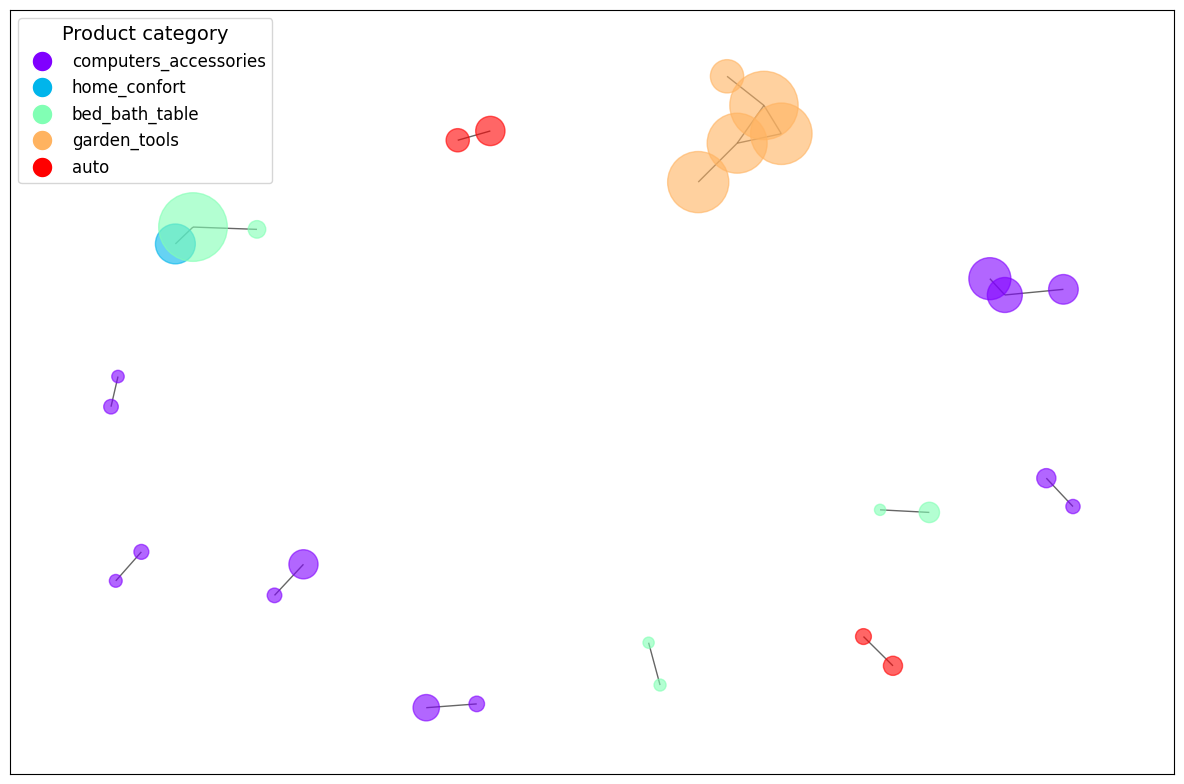

In [71]:
# data visualization

import networkx as nx

G = nx.Graph()
# Add nodes to the graph
for _, product in most_ordered_products_df.iterrows():
    G.add_node(product['product_id'], category=product['category'], orders_count=product['orders_count'])
# Add edges to the graph
for _, pair in products_often_ordered_together_df.iterrows():
    G.add_edge(pair['product_id1'], pair['product_id2'], weight=pair['common_orders_count'])
# Remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))
# Assign colors to categories
categories = list(set(nx.get_node_attributes(G, 'category').values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
category_colors = dict(zip(categories, colors))
# Draw the graph
plt.figure(figsize=(12, 8))
position = nx.spring_layout(G, k=0.5, iterations=50)
node_sizes = [G.nodes[n]['orders_count'] * 5 for n in G.nodes]
node_colors = [category_colors[G.nodes[n]['category']] for n in G.nodes]
nx.draw_networkx(G, position, node_color=node_colors, node_size=node_sizes, alpha=0.6, with_labels=False)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=15)
                   for category, color in category_colors.items()]
plt.legend(handles=legend_elements, title="Product category", loc='upper left', title_fontsize=14)
plt.tight_layout()
plt.show()

There are 5 products in the Garden tools category that are often bought together. There's also a product from the Bed, Bath, Table category that is often bought together with another from the Home confort category. We can also observe that some products in the Auto and Computer accessories categories are also often bought with other items of the same category.

In [72]:
view_table('sellers', 5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [73]:
# analyze Olist's sellers, are most of them small businesses or large orgs?
seller_review_scores_and_sales = '''
SELECT
    sellers.seller_id,
    AVG(order_reviews.review_score) AS avg_review_score,
    SUM(order_items.price) AS total_sales,
    COUNT(orders.order_id) AS num_orders
FROM
    sellers
    LEFT JOIN order_items ON sellers.seller_id = order_items.seller_id
    LEFT JOIN orders ON order_items.order_id = orders.order_id
    LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
GROUP BY
    sellers.seller_id
HAVING
    COUNT(orders.order_id) > 10
'''

df = pd.read_sql_query(seller_review_scores_and_sales, db_connection)
df

,seller_id,avg_review_score,total_sales,num_orders
0,001cca7ae9ae17fb1caed9dfb1094831,3.902542,25080.03,239
1,002100f778ceb8431b7a1020ff7ab48f,3.982143,1254.40,56
2,004c9cd9d87a3c30c522c48c4fc07416,4.132948,20467.18,176
3,00720abe85ba0859807595bbf045a33b,3.653846,1007.50,26
4,00ee68308b45bc5e2660cd833c3f81cc,4.331395,20345.00,173
...,...,...,...,...
1310,ffc470761de7d0232558ba5e786e57b7,4.300000,1649.01,31
1311,ffdd9f82b9a447f6f8d4b91554cc7dd3,4.250000,2101.20,20
1312,ffeee66ac5d5a62fe688b9d26f83f534,4.214286,1839.86,14
1313,fffd5413c0700ac820c7069d66d98c89,3.866667,9062.30,61


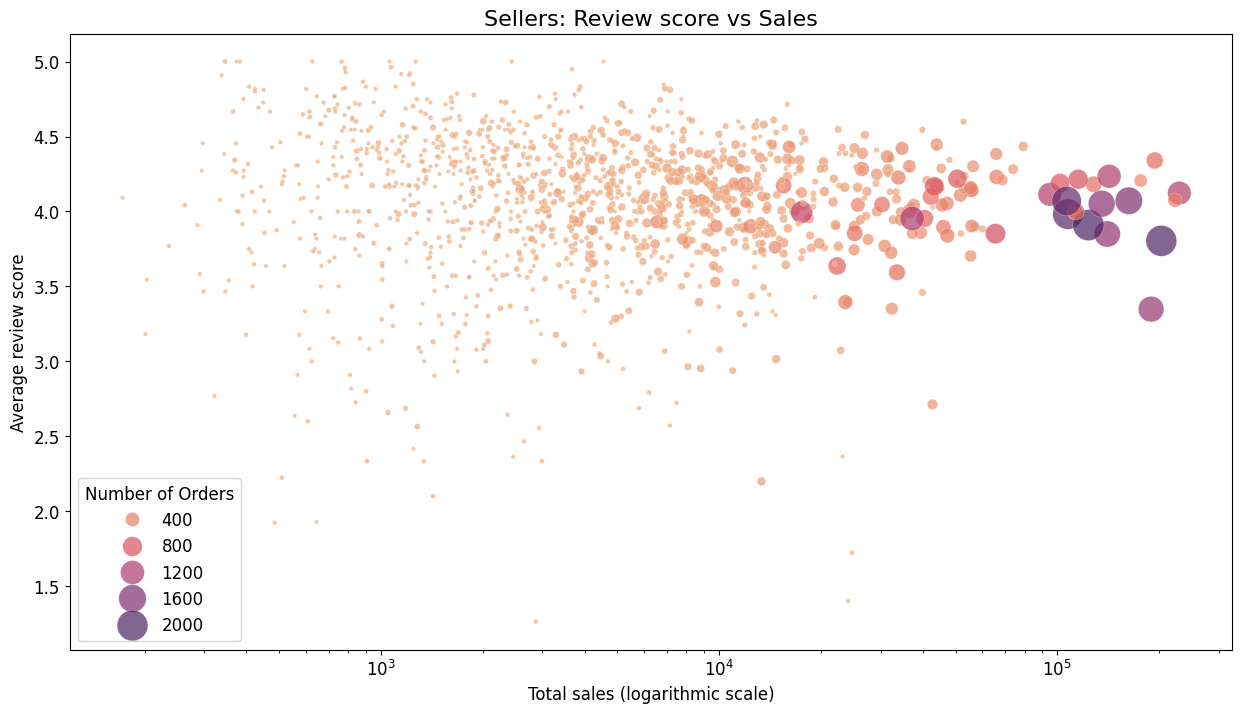

In [74]:
# data visualization
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='total_sales', y='avg_review_score', size='num_orders', sizes=(10, 500),
                hue='num_orders', palette='flare', alpha=0.7)
plt.xscale('log')
plt.xlabel('Total sales (logarithmic scale)')
plt.ylabel('Average review score')
plt.title('Sellers: Review score vs Sales')
plt.legend(title='Number of Orders')
plt.show()

most of Olist's sellers are small, with just a few orders. As you'd expect, larger sellers have less variance in their average order review scores, with most sellers being in the range between 3.5 and 4.5

In [75]:
bucketed_sellers = """
SELECT
    seller_id,
    CASE
        WHEN COUNT(order_id) BETWEEN 1 AND 9 THEN '1-9 orders'
        WHEN COUNT(order_id) BETWEEN 10 AND 99 THEN '10-99 orders'
        WHEN COUNT(order_id) BETWEEN 100 AND 999 THEN '100-999 orders'
        ELSE '1000+ orders'
    END AS bucket
FROM order_items
GROUP BY seller_id
"""

pd.read_sql_query(bucketed_sellers, db_connection).head(5)


,seller_id,bucket
0,0015a82c2db000af6aaaf3ae2ecb0532,1-9 orders
1,001cca7ae9ae17fb1caed9dfb1094831,100-999 orders
2,001e6ad469a905060d959994f1b41e4f,1-9 orders
3,002100f778ceb8431b7a1020ff7ab48f,10-99 orders
4,003554e2dce176b5555353e4f3555ac8,1-9 orders


In [76]:
sellers_per_bucket = f"""
WITH BucketedSellers AS (
    {bucketed_sellers}
)
SELECT
    bucket,
    COUNT(seller_id) AS seller_count
FROM BucketedSellers
GROUP BY bucket
"""

seller_buckets = pd.read_sql_query(sellers_per_bucket, db_connection)
seller_buckets

,bucket,seller_count
0,1-9 orders,1714
1,10-99 orders,1142
2,100-999 orders,226
3,1000+ orders,13


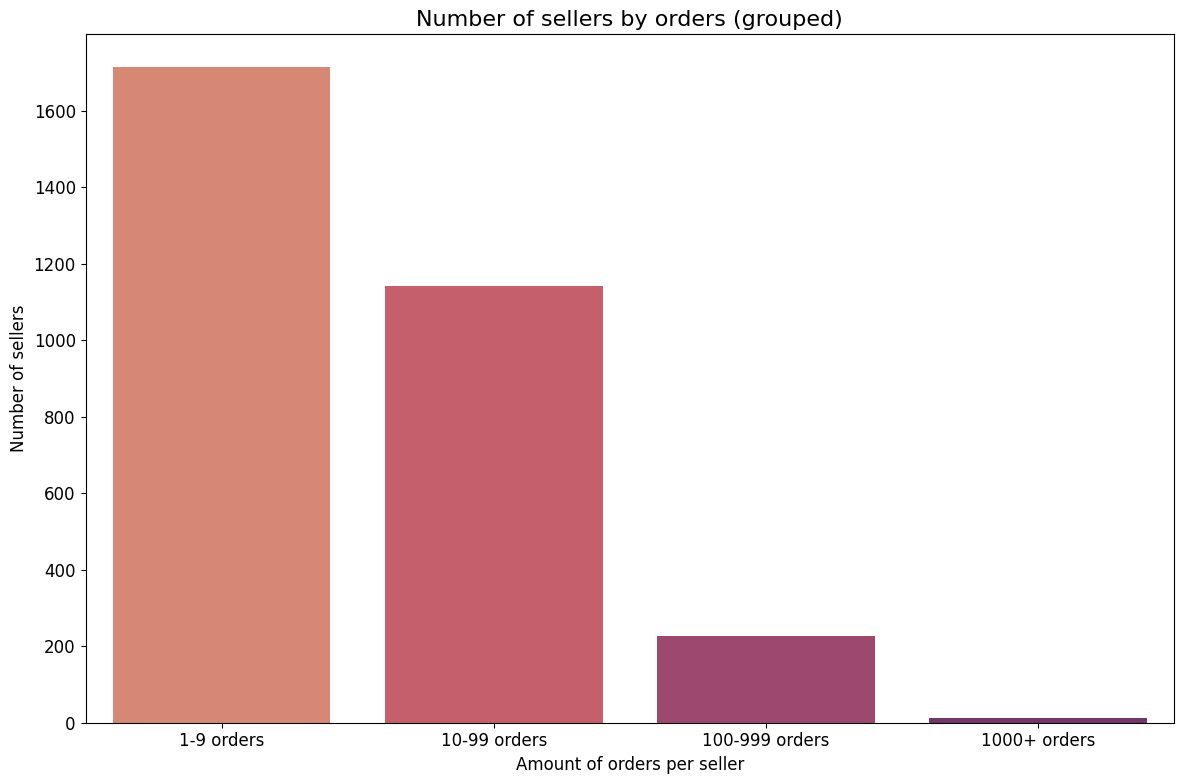

In [77]:
plt.figure(figsize=(12, 8))
sns.barplot(x='bucket', y='seller_count', data=seller_buckets, hue='bucket', palette='flare', dodge=False)
plt.title('Number of sellers by orders (grouped)')
plt.xlabel('Amount of orders per seller')
plt.ylabel('Number of sellers')
plt.tight_layout()
plt.show()

Olist's customer base is comrpised of mostly small businesses with low order volume

In [78]:
# do larger sellers have lower shipping times?
seller_shipping_times = f"""
WITH BucketedSellers AS (
    {bucketed_sellers}
)
SELECT
    bucket,
    BucketedSellers.seller_id,
    JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)
        AS delivery_time
FROM orders
    JOIN order_items USING (order_id)
    JOIN BucketedSellers USING (seller_id)
WHERE order_status = 'delivered'
"""

df = pd.read_sql_query(seller_shipping_times, db_connection)
df

,bucket,seller_id,delivery_time
0,10-99 orders,3504c0cb71d7fa48d967e0e4c94d59d9,8.436574
1,100-999 orders,289cdb325fb7e7f891c38608bf9e0962,13.782037
2,1000+ orders,4869f7a5dfa277a7dca6462dcf3b52b2,9.394213
3,100-999 orders,66922902710d126a0e7d26b0e3805106,13.208750
4,100-999 orders,2c9e548be18521d1c43cde1c582c6de8,2.873877
...,...,...,...
110192,10-99 orders,1f9ab4708f3056ede07124aad39a2554,22.193727
110193,10-99 orders,d50d79cb34e38265a8649c383dcffd48,24.859421
110194,100-999 orders,a1043bafd471dff536d0c462352beb48,17.086424
110195,100-999 orders,a1043bafd471dff536d0c462352beb48,17.086424


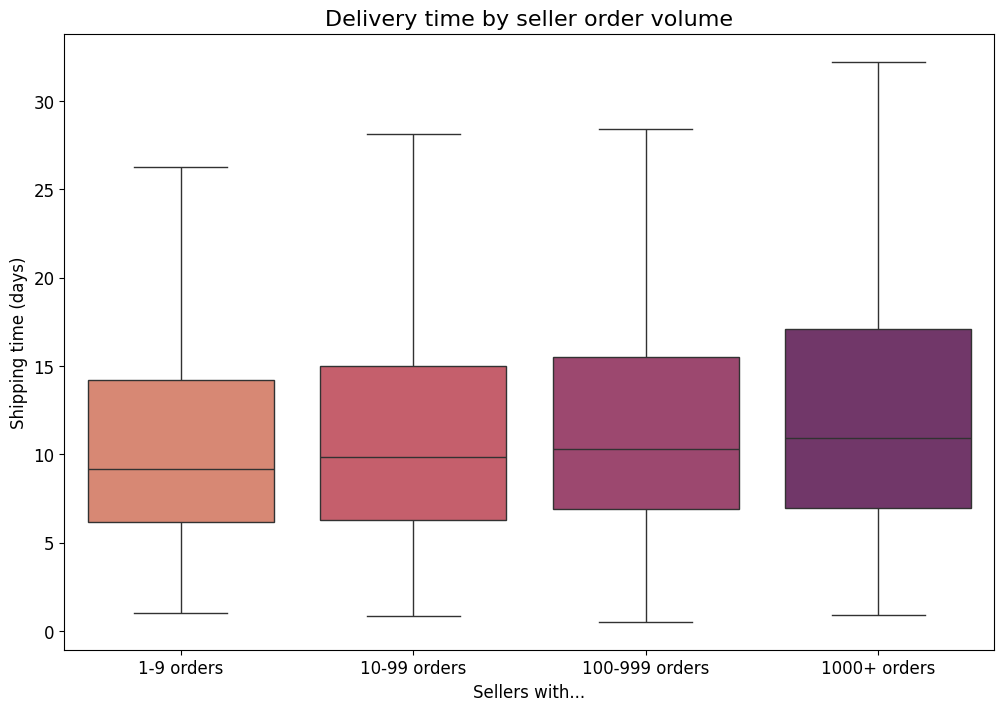

In [79]:
# data visualizations
plt.figure(figsize=(12, 8))
palette = sns.color_palette('flare', len(seller_buckets['bucket']))
sns.boxplot(x='bucket', y='delivery_time', data=df, order=seller_buckets['bucket'], showfliers=False,
            hue='bucket', palette=palette[1:]+palette[:1], dodge=False)
plt.title('Delivery time by seller order volume')
plt.xlabel('Sellers with...')
plt.ylabel('Shipping time (days)')
plt.legend().remove()
plt.show()

larger sellers do have longer shipping times and more variance

In [80]:
view_table('leads_qualified', 5)

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


In [81]:
view_table('leads_closed', 5)

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,None,None,None,reseller,None,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,None,None,None,reseller,None,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,None,None,None,reseller,None,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,None,None,None,None,reseller,None,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,None,None,None,manufacturer,None,0.0


In [82]:
lead_conversion = """
SELECT
    COALESCE(origin, 'unknown') AS origin,
    COUNT(DISTINCT leads_qualified.mql_id) AS qualified_leads,
    COUNT(DISTINCT leads_closed.mql_id) AS closed_leads,
    COUNT(DISTINCT leads_closed.mql_id) * 100.0 / COUNT(DISTINCT leads_qualified.mql_id)
        AS conversion_rate
FROM leads_qualified
    LEFT JOIN leads_closed USING (mql_id)
GROUP BY COALESCE(origin, 'unknown')
ORDER BY COUNT(leads_qualified.mql_id) DESC
"""

df = pd.read_sql_query(lead_conversion, db_connection)
df

,origin,qualified_leads,closed_leads,conversion_rate
0,organic_search,2296,271,11.803136
1,paid_search,1586,195,12.295082
2,social,1350,75,5.555556
3,unknown,1159,193,16.652286
4,direct_traffic,499,56,11.222445
5,email,493,15,3.042596
6,referral,284,24,8.450704
7,other,150,4,2.666667
8,display,118,6,5.084746
9,other_publicities,65,3,4.615385


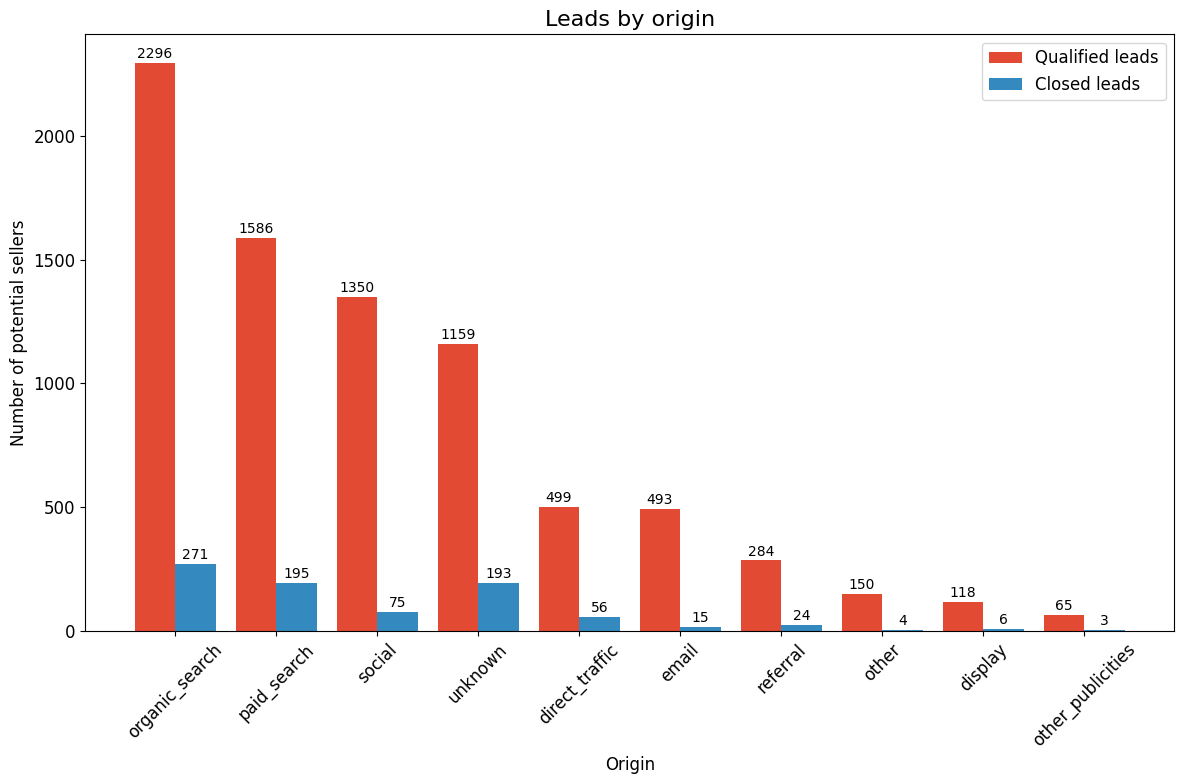

In [83]:
# data visualization
plt.figure(figsize=(12, 8))
bar_width = 0.4
r1 = range(len(df))
r2 = [x + bar_width for x in r1]
plt.bar(r1, df['qualified_leads'], color='#e24a33', width=bar_width, label='Qualified leads')
plt.bar(r2, df['closed_leads'], color='#348abe', width=bar_width, label='Closed leads')
for i, v in enumerate(df['qualified_leads']):
    plt.text(i, v + 20, str(v), ha='center', fontsize=10)
for i, v in enumerate(df['closed_leads']):
    plt.text(i + bar_width, v + 20, str(v), ha='center', fontsize=10)
plt.xlabel('Origin')
plt.ylabel('Number of potential sellers')
plt.title('Leads by origin')
plt.xticks([r + bar_width / 2 for r in range(len(df))], df['origin'],
           rotation=45, color='black', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Olist doesn't seem to convert many leads to users of their platform. Their largest source is organic search, which is good

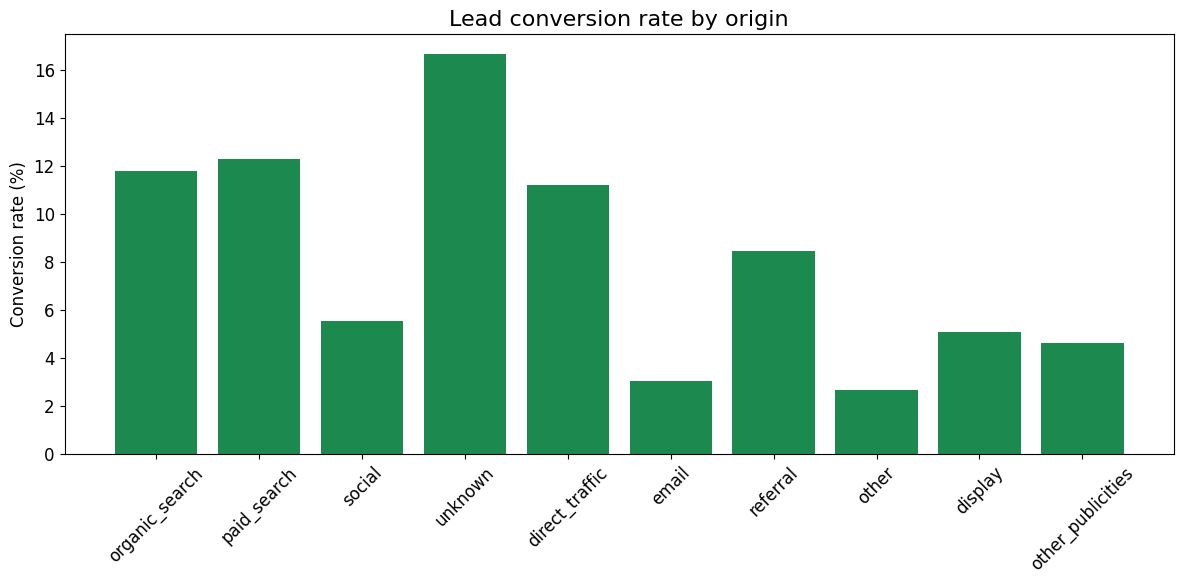

In [84]:
# data visualization
plt.figure(figsize=(12, 6))
plt.bar(df['origin'], df['conversion_rate'], color='#1c8a4f')
plt.ylabel('Conversion rate (%)')
plt.title('Lead conversion rate by origin')
plt.xticks(rotation=45, color='black', fontsize=12)
plt.tight_layout()
plt.show()